# Experiments to find which multi-classification models perform best

In [1]:
import time
import os
import glob
import re
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

import ray

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
run_experiments = True

In [ ]:
incerto_dir = './'
output_dir = os.path.join(incerto_dir, 'output')

## Set up

In [4]:
scalers = {'StandardScaler': StandardScaler(),
           'L1': Normalizer(norm='l1'),
           'L2': Normalizer(norm='l2')}

In [5]:
def build_vectorizer(_typ, _ngram, _max, _min, _max_f):

    if _max_f == 'None':
        _max_f = None

    if _typ == 'Count':
        vec = CountVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2],
                    max_df=_max,
                    min_df=_min,
                    max_features=_max_f)

    elif _typ == 'TfIdf':
        vec = TfidfVectorizer(input='content',
                    encoding='utf-8',
                    lowercase=True,
                    analyzer=_ngram[0].lower(),
                    ngram_range=_ngram[2],
                    max_df=_max,
                    min_df=_min,
                    max_features=_max_f,
                    norm=None)
    return vec

In [6]:
matrix_options = {'vectorizer':['Count', 'TfIdf'],
           'ngram': [['Char','Bigrams', (2,2)],['Char','Trigrams', (3,3)],['Word','Unigrams', (1,1)]],
           'max_df': [0.8,0.9,1.0],
           'min_df': [0.0,0.1,0.2],
           'max_f': ['None', 1000],
           'scaler': scalers.keys()}

In [7]:
total = matrix_options.values()
matrix_combos = list(product(*total))
print(len(matrix_combos))
matrix_combos[0]

324


('Count', ['Char', 'Bigrams', (2, 2)], 0.8, 0.0, 'None', 'StandardScaler')

In [8]:
classifiers = {
  'RandomForest': RandomForestClassifier(),
  'kNN': KNeighborsClassifier(),
  'Logit': LogisticRegression(max_iter=500),
  'SVM': SVC()}

## Experiments

In [10]:
if run_experiments == True:
    ray.init(num_cpus=6)

2023-04-30 19:46:09,094	INFO worker.py:1553 -- Started a local Ray instance.


In [ ]:
@ray.remote
def do_classification(_combo, _scaled_X, _golden_labels, _classifiers, _classifier, _num_f, _typ, _path):

    scores = cross_validate( # perform cross-validation
            _classifiers[_classifier], # classifier object
            _scaled_X, # feature matrix
            _golden_labels, # gold labels
            cv=3, #number of folds
            scoring=['f1_macro']) # scoring methods
    scores_df = pd.DataFrame(scores).mean()

    with open(_path, 'a') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow((_classifier, _combo[0],
                            _combo[1][0], _combo[1][1],
                            _combo[2], _combo[3], _combo[4], _num_f,
                            _combo[5], scores_df.loc['test_f1_macro'], _typ))

In [12]:
# 8 is the number of authors we are training on and 2 is the number of poem types
len(matrix_combos)*len(classifiers.keys())*2

2592

In [13]:
classification_path = os.path.join(output_dir, f'multi_classification_performance.csv')
if not os.path.exists(classification_path):
    with open(classification_path, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(('classifier', 'vectorizer',
                            'ngram type', 'ngram range',
                            'max_df', 'min_df', 'max_f', 'num_f',
                            'scaler', 'f1-score', 'type'))

In [14]:
if run_experiments == True:

    for typ in ['Split', 'Whole']:

        poems_path = os.path.join(incerto_dir, 'data', 'poems', f'poems_{typ.lower()}.csv')
        all_poems_df = pd.read_csv(poems_path)
        print(f'All {typ} poems:\t', len(all_poems_df))
        poems_df = all_poems_df.loc[all_poems_df['author'] != 'Unknown']
        print(f'Known {typ} poems:\t', len(poems_df))

        for combo in matrix_combos:
            
            if combo[1][0] == 'Char':
                poems = [re.sub(r'\s+', '', x) for x in poems_df['poem'].tolist()]
            elif combo[1][0] == 'Word':
                poems = poems_df['poem'].tolist()
            vectorizer = build_vectorizer(combo[0], combo[1], combo[2], combo[3], combo[4])

            X = vectorizer.fit_transform(poems)
            num_f = X.shape[1]
            scaled_X = scalers[combo[5]].fit_transform(X.toarray())

            futures = []
        
            golden_labels = poems_df['author'].tolist()

            for classifier in classifiers.keys():

                # do_classification(combo, scaled_X, golden_labels, classifiers, classifier, num_f, typ, classification_path)

                futures.append(do_classification.remote(combo, scaled_X, golden_labels, classifiers, classifier, num_f, typ, classification_path))

            results = ray.get(futures)

All Split poems:	 682
Known Split poems:	 622
All Whole poems:	 339
Known Whole poems:	 332


In [15]:
results_df = pd.read_csv(classification_path)
print(len(results_df))
results_df.head()

2592


,classifier,vectorizer,ngram type,ngram range,max_df,min_df,max_f,num_f,scaler,f1-score,type
0,kNN,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.199112,Split
1,Logit,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.348010,Split
2,SVM,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.170635,Split
3,RandomForest,Count,Char,Bigrams,0.8,0.0,None,243,StandardScaler,0.158649,Split
4,kNN,Count,Char,Bigrams,0.8,0.0,None,243,L1,0.095981,Split


## Evaluating overall performance

In [20]:
def make_figure(hue_label):

    plt.figure(figsize=(5, 5))
    ax = sns.boxplot(x=hue_label.lower(), y='f1-score', data=results_df)#, hue=hue_label.lower())
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.xlabel(hue_label)
    plt.ylabel('F1-score (macro avg)')
    plt.title(f'Performance of different {hue_label.lower()}s')
    plt.show()

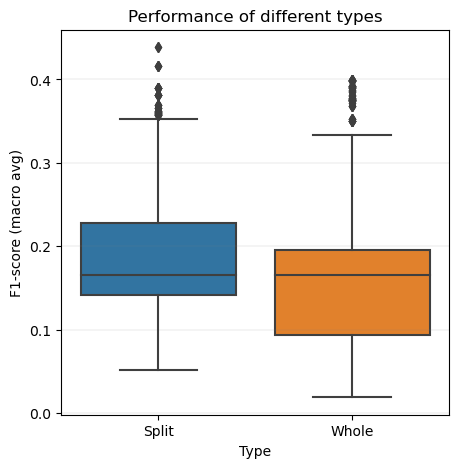

In [21]:
make_figure('Type')

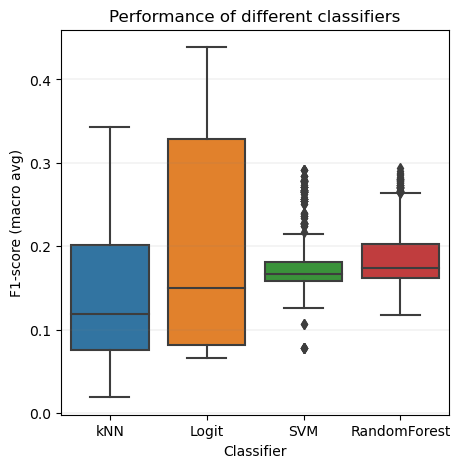

In [22]:
make_figure('Classifier')

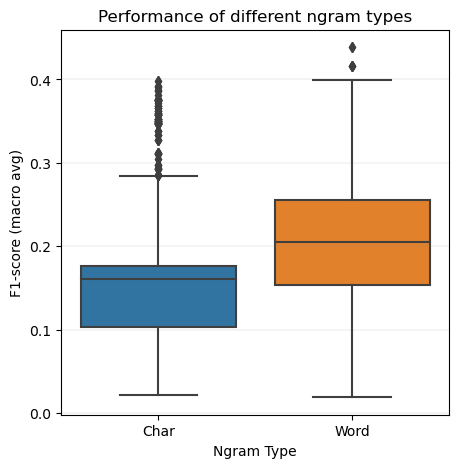

In [23]:
make_figure('Ngram Type')

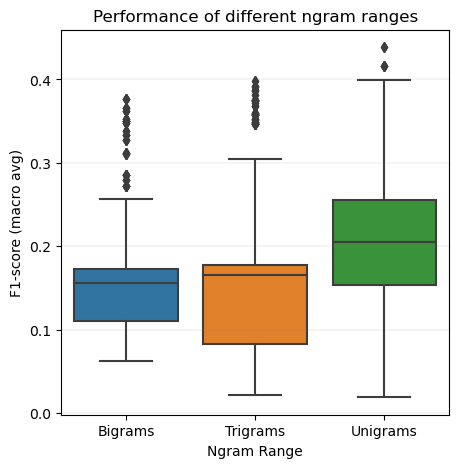

In [24]:
make_figure('Ngram Range')

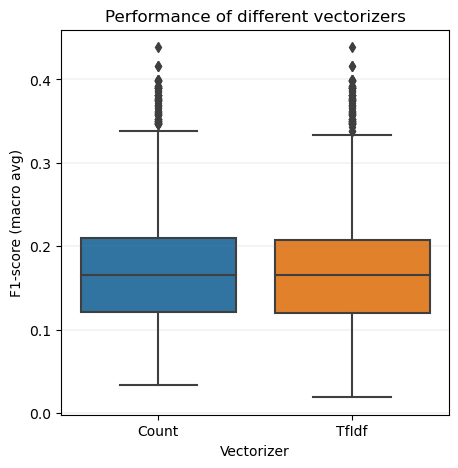

In [25]:
make_figure('Vectorizer')

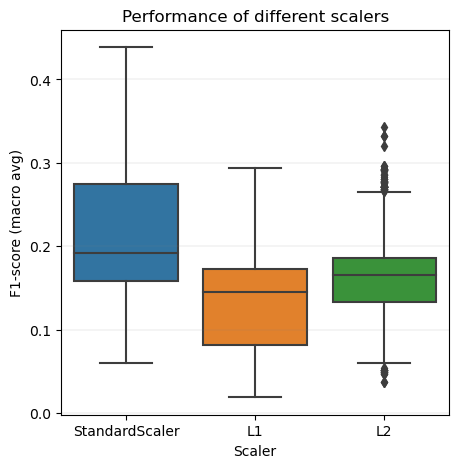

In [26]:
make_figure('Scaler')